In [1]:
import os, sys
os.chdir(os.path.dirname(sys.prefix))
# print(f"Рабочая директория: {os.getcwd()}")

In [5]:
import cv2

In [3]:
from src.tsp_dewarp.dataset import TPSDataset
from src.tsp_dewarp.geometry import build_remap_from_delta_tps

In [35]:
DATASET_FOLDER = 'data/generated/v2/'
dataset = TPSDataset(DATASET_FOLDER, transform=lambda input: input)
len(dataset)

300

In [44]:
img_path = 'data/generated/v2/latex_269_warped.png'
img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

In [45]:
pred_delta = dataset[268][1].numpy()
pred_delta[:5]

array([[ 0.05354515,  0.06060775],
       [ 0.03190208,  0.04560612],
       [ 0.01289956,  0.02977397],
       [-0.00339385,  0.01275391],
       [-0.01690737, -0.00569201]], dtype=float32)

In [ ]:
map_x, map_y = build_remap_from_delta_tps(
    delta_tps=pred_delta,  # (25,2)
    H=img.shape[0],
    W=img.shape[1],
    grid_size=7,
    clip=False # УБРАТЬ ОБРЕЗКУ!!!
)

rectified = cv2.remap(
    img,
    map_x,
    map_y,
    interpolation=cv2.INTER_CUBIC,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=255
)

In [47]:
cv2.imwrite('data/restored.png', rectified)

True

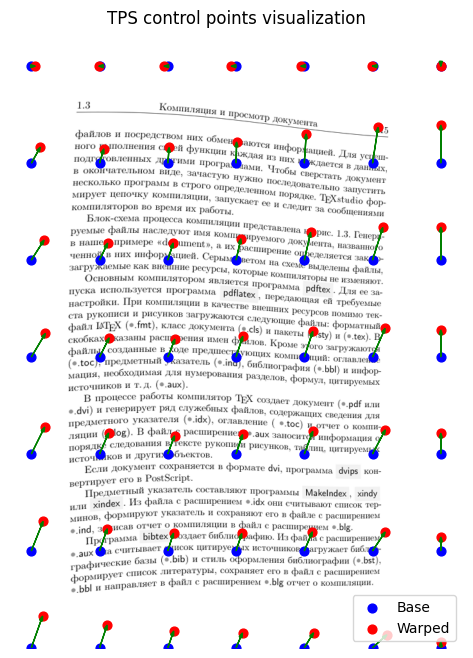

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ===============================
# 1. Загрузить изображение
# ===============================

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

H, W = img.shape[:2]

# ===============================
# 2. Задать deltaTPS (пример)
# ===============================
# Если есть предсказание модели:
# delta = pred_delta  # shape (25, 2)

# Пример случайного delta для теста:
delta = pred_delta

grid_size = 7

# ===============================
# 3. Построить базовую сетку
# ===============================

s = np.linspace(0.0, 1.0, grid_size)
t = np.linspace(0.0, 1.0, grid_size)

P_base_norm = np.array([(sx, ty) for ty in t for sx in s])

P_warp_norm = P_base_norm + delta

# при необходимости
P_warp_norm = np.clip(P_warp_norm, 0.0, 1.0)

# ===============================
# 4. Перевод в пиксели
# ===============================

P_base_px = np.column_stack([
    P_base_norm[:, 0] * (W - 1),
    P_base_norm[:, 1] * (H - 1)
])

P_warp_px = np.column_stack([
    P_warp_norm[:, 0] * (W - 1),
    P_warp_norm[:, 1] * (H - 1)
])

# ===============================
# 5. Визуализация
# ===============================

plt.figure(figsize=(8, 8))
plt.imshow(img)

# базовые точки
plt.scatter(P_base_px[:, 0], P_base_px[:, 1],
            c='blue', s=40, label="Base")

# искажённые точки
plt.scatter(P_warp_px[:, 0], P_warp_px[:, 1],
            c='red', s=40, label="Warped")

# стрелки смещения
for i in range(len(P_base_px)):
    plt.arrow(
        P_base_px[i, 0],
        P_base_px[i, 1],
        P_warp_px[i, 0] - P_base_px[i, 0],
        P_warp_px[i, 1] - P_base_px[i, 1],
        color='green',
        head_width=5,
        length_includes_head=True
    )

plt.legend()
plt.title("TPS control points visualization")
plt.axis("off")
plt.show()
    